# _Part 1: Set-up_

In [1]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [36]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [5]:
path.ls()

[PosixPath('/home/jupyter/springboard-capstone-2/data/train_atel.csv'),
 PosixPath('/home/jupyter/springboard-capstone-2/data/CheXpert-v1.0-small'),
 PosixPath('/home/jupyter/springboard-capstone-2/data/models'),
 PosixPath('/home/jupyter/springboard-capstone-2/data/.ipynb_checkpoints')]

# _Part 2: Data Preparation_

In [12]:
train_df = pd.read_csv(path/'CheXpert-v1.0-small/train.csv')

In [13]:
train_df.head().T

,0,1,2,3,4
Path,CheXpert-v1.0-small/train/patient00001/study1/...,CheXpert-v1.0-small/train/patient00002/study2/...,CheXpert-v1.0-small/train/patient00002/study1/...,CheXpert-v1.0-small/train/patient00002/study1/...,CheXpert-v1.0-small/train/patient00003/study1/...
Sex,Female,Female,Female,Female,Male
Age,68,87,83,83,41
Frontal/Lateral,Frontal,Frontal,Frontal,Lateral,Frontal
AP/PA,AP,AP,AP,NaN,AP
No Finding,1,NaN,NaN,NaN,NaN
Enlarged Cardiomediastinum,NaN,NaN,NaN,NaN,NaN
Cardiomegaly,NaN,-1,NaN,NaN,NaN
Lung Opacity,NaN,1,1,1,NaN
Lung Lesion,NaN,NaN,NaN,NaN,NaN


In [8]:
n = len(train_df)
n

223414

In [14]:
valid_df = pd.read_csv(path/'CheXpert-v1.0-small/valid.csv')

In [15]:
valid_df.head().T

,0,1,2,3,4
Path,CheXpert-v1.0-small/valid/patient64541/study1/...,CheXpert-v1.0-small/valid/patient64542/study1/...,CheXpert-v1.0-small/valid/patient64542/study1/...,CheXpert-v1.0-small/valid/patient64543/study1/...,CheXpert-v1.0-small/valid/patient64544/study1/...
Sex,Male,Male,Male,Male,Female
Age,73,70,70,85,42
Frontal/Lateral,Frontal,Frontal,Lateral,Frontal,Frontal
AP/PA,AP,PA,NaN,AP,AP
No Finding,0,0,0,0,1
Enlarged Cardiomediastinum,1,0,0,1,0
Cardiomegaly,1,0,0,0,0
Lung Opacity,1,0,0,1,0
Lung Lesion,0,0,0,0,0


In [16]:
len(valid_df)

234

In [9]:
# competition tasks (pathologies) divided into best performing uncertatinty approachs (limited to U-One/U-Zero)
u_one_features = ['Atelectasis', 'Edema', 'Pleural Effusion']
u_zero_features = ['Cardiomegaly', 'Consolidation']

In [22]:
# add target features string
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [23]:
# apply feature string to train and validation set
train_df['feature_string'] = train_df.apply(feature_string, axis=1)
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,feature_string
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,Atelectasis;Edema;Pleural Effusion
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Edema


In [24]:
valid_df['feature_string'] = valid_df.apply(feature_string, axis=1)
valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,feature_string
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiomegaly
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Edema
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,


### Get Patient ID

In [41]:
train_df['patient'] = train_df.Path.str.split('/',3,True)[2]
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,feature_string,patient
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,,patient00001
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,Atelectasis;Edema;Pleural Effusion,patient00002
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,,patient00002
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,,patient00002
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Edema,patient00003


In [42]:
valid_df['patient'] = valid_df.Path.str.split('/',3,True)[2]
valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,feature_string,patient
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiomegaly,patient64541
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,patient64542
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,patient64542
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Edema,patient64543
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,patient64544


# _Part 3: Experimenting with a sample_

In [43]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [46]:
def get_sample_df(sample_perc = 0.05):
    unique_patients = train_df.patient.unique()
    mask = np.random.rand(len(unique_patients)) <= sample_perc
    sample_patients = unique_patients[mask]

    sample_df = train_df[train_df.patient.isin(sample_patients)]
    return sample_df

In [47]:
seed_everything(1)

In [52]:
sample_train_df = get_sample_df(sample_perc=0.10)
sample_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,feature_string,patient
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,,patient00005
8,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,,patient00005
9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,,patient00005
10,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,,patient00005
44,CheXpert-v1.0-small/train/patient00015/study1/...,Female,76,Frontal,AP,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,Edema,patient00015


In [55]:
sample_train_df = sample_train_df[['Path', 'feature_string']].reset_index(drop=True)
valid_df = valid_df[['Path', 'feature_string']]

In [56]:
sample_train_df.head()

,Path,feature_string
0,CheXpert-v1.0-small/train/patient00005/study1/...,
1,CheXpert-v1.0-small/train/patient00005/study1/...,
2,CheXpert-v1.0-small/train/patient00005/study2/...,
3,CheXpert-v1.0-small/train/patient00005/study2/...,
4,CheXpert-v1.0-small/train/patient00015/study1/...,Edema


In [57]:
valid_df.head()

,Path,feature_string
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Cardiomegaly
1,CheXpert-v1.0-small/valid/patient64542/study1/...,
2,CheXpert-v1.0-small/valid/patient64542/study1/...,
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Edema
4,CheXpert-v1.0-small/valid/patient64544/study1/...,


# _Set Up For DL Training_

In [58]:
# default transformations
tfms = get_transforms()

In [59]:
src = (ImageList.from_df(df=sample_train_df, path=path, folder='.', suffix=''))

In [60]:
src = src.split_by_rand_pct(0.1)

In [62]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 7134MB of GPU RAM free


In [63]:
data = (src.label_from_df(cols='feature_string')
        .transform(tfms, size=224)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [64]:
data.add_test(ImageList.from_df(valid_df, path=path, folder='.', suffix=''))

In [65]:
data

ImageDataBunch;

Train: LabelList (19666 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
,,,,Edema
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (2185 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
,Consolidation,Cardiomegaly,Atelectasis;Edema;Cardiomegaly,Pleural Effusion;Cardiomegaly
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/springboard-capstone-2/data

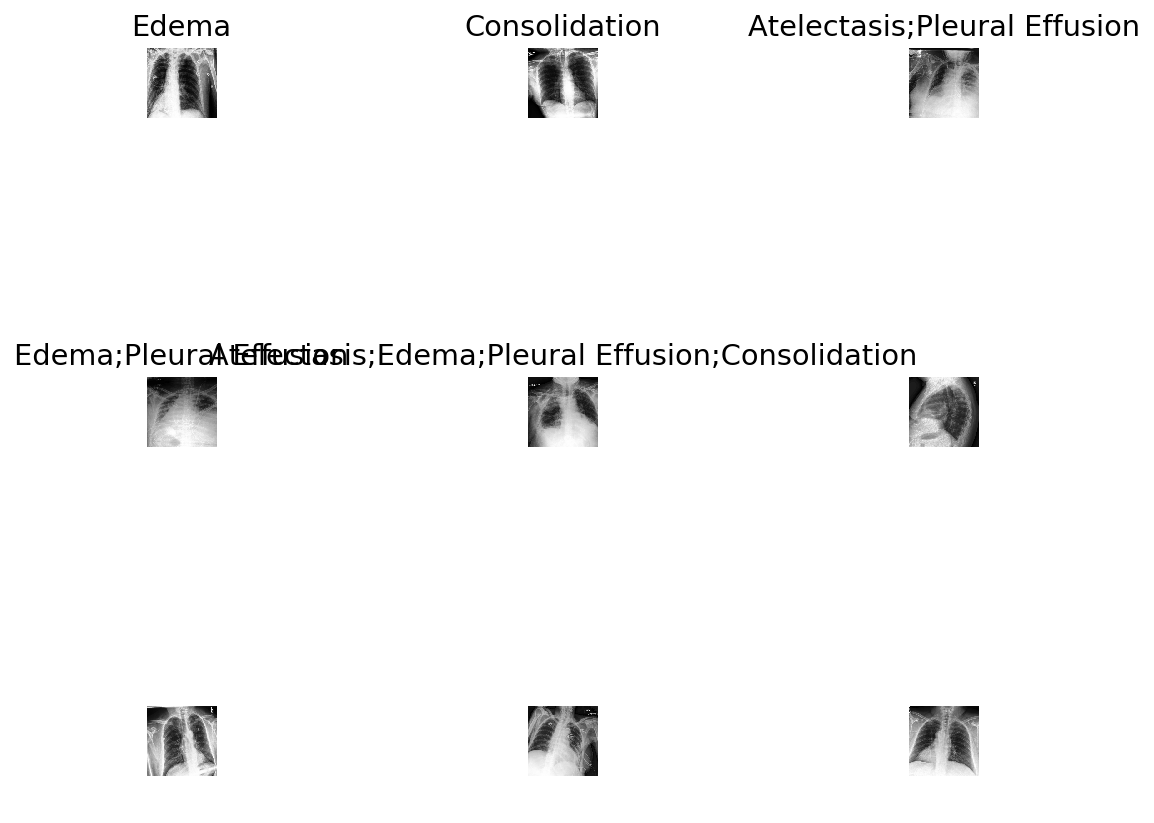

In [66]:
data.show_batch(rows=3, figsize=(7,7))

# Baseline DL Model

In [67]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [75]:
learn13 = cnn_learner(data=data, base_arch=models.resnet152, metrics=[accuracy, error_rate], pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-02
Min loss divided by 10: 7.08E-03


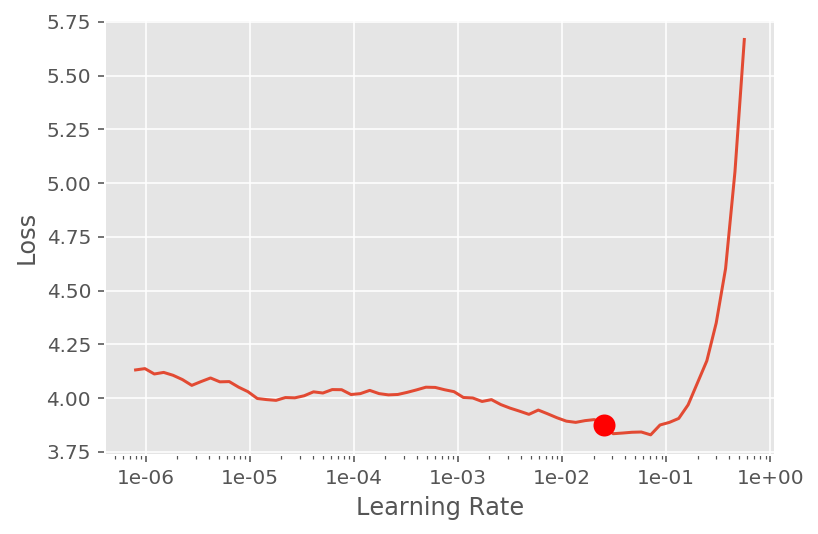

In [76]:
learn13.lr_find(start_lr=1e-7, end_lr=100)
learn13.recorder.plot(suggestion=True)

In [77]:
lr = 1e-2
lr

0.01

# _Rd. 1 Training_

In [78]:
learn13.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.453220,2.558170,0.286041,0.713959,07:39
1,2.444897,2.987515,0.296567,0.703433,07:37
2,2.231743,3.088181,0.342334,0.657666,07:36
3,2.186617,2.124219,0.356979,0.643021,07:37


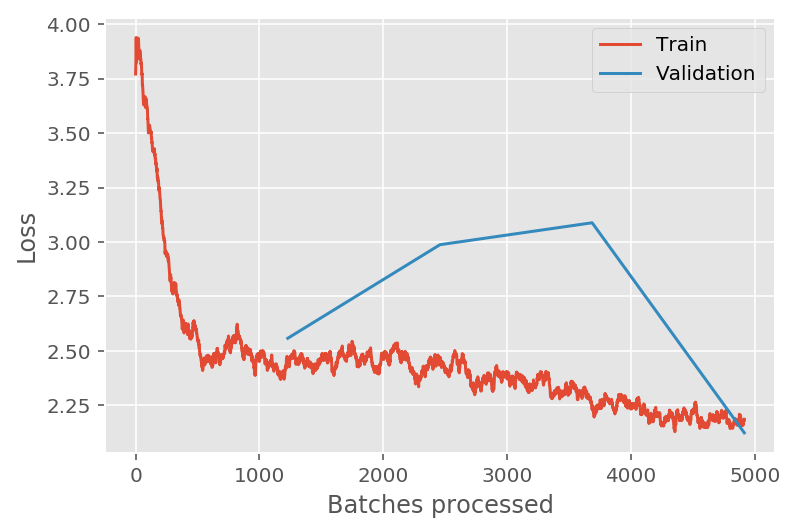

In [88]:
learn13.recorder.plot_losses()

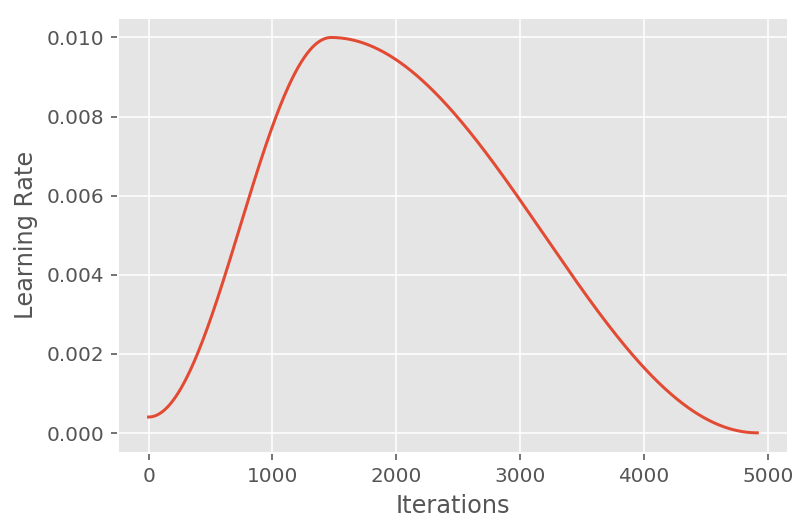

In [90]:
learn13.recorder.plot_lr()

In [91]:
learn13.save('learn13-rd1-rn152')

# _Rd. 2 Training_ - Unfreezing, fine-tuning, and learning rates

In [93]:
# load previous weights
learn13.load('learn13-rd1-rn152');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-07
Min loss divided by 10: 9.77E-08


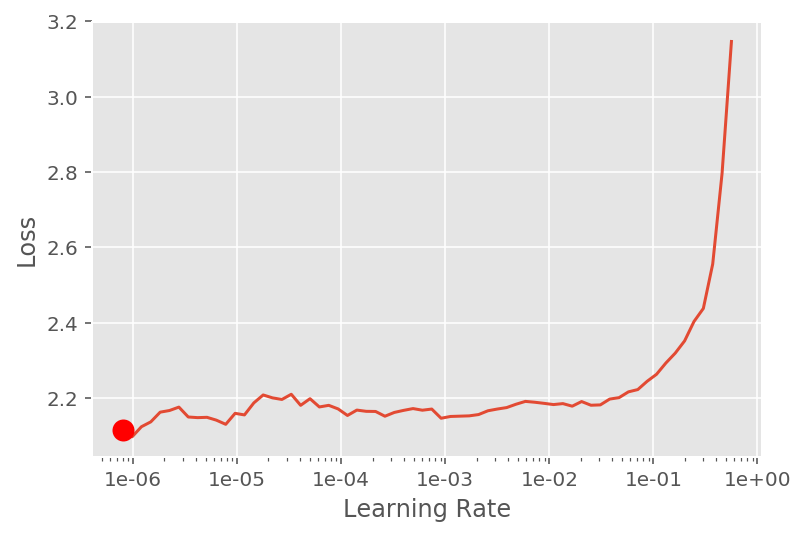

In [94]:
learn13.lr_find(start_lr=1e-7, end_lr=100)
learn13.recorder.plot(suggestion=True)

In [95]:
# unfreeze the model allowing pretrained weights to move around
learn13.unfreeze()

learn13.fit_one_cycle(2, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.122285,2.719933,0.361098,0.638902,10:22
1,2.234172,2.195844,0.361098,0.638902,10:23
